In [1]:
%matplotlib widget
from pathlib import Path
import sys
import os
base_path = Path(os.path.abspath('')).parent
print(base_path)
sys.path.append(str(base_path))
import torch
from modules.tensor_nerf import TensorNeRF
from fields.listrf import ListRF
from samplers.nerf_acc import NerfAccSampler
from icecream import ic
from IPython.display import Image


import imageio

import matplotlib.pyplot as plt


def disp_im(im):
    plt.close()
    plt.cla()
    fig = plt.imshow(im)
    plt.close()
    display(fig.figure)
def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

/home/amai/normalrf
Warp 0.6.2 initialized:
   CUDA Toolkit: 11.5, Driver: 12.0
   Devices:
     "cpu"    | CPU
     "cuda:0" | NVIDIA GeForce RTX 3090 (sm_86)
   Kernel cache: /home/amai/.cache/warp/0.6.2


In [2]:


log_dir = Path("../log")# / "noprednorms_nl0_conserve_pb0"
ckpt1 = log_dir / 'materials_v38_interpdiffuse' / 'materials_v38_interpdiffuse.th'

tensorf = TensorNeRF.load(torch.load(ckpt1), near_far=[2, 6], strict=False)
device = torch.device('cuda')
tensorf = tensorf.to(device)

# tensorf.sampler.update(tensorf.rf, init=True)
# for i in range(1000):
#     tensorf.sampler.check_schedule(i, 1, tensorf.rf)

ic| grid_size: [tensor(300, device='cuda:0'),
                tensor(300, device='cuda:0'),
                tensor(300, device='cuda:0')]
ic| self.N_voxel_list: [347217, 1279813, 3167271, 6346304, 11153628, 17925958, 27000000]
ic| self.use_predicted_normals: False
    self.align_pred_norms: True
    self.orient_world_normals: True


grid size tensor([300, 300, 300])
aabb tensor([-1.5000, -1.5000, -1.5000,  1.5000,  1.5000,  1.5000], device='cuda:0')
sampling step size:  tensor(0.0050)
sampling number:  1036


In [3]:


from dataLoader.ray_utils import get_ray_directions, get_rays
from renderer import chunk_renderer, BundleRender
import numpy as np

w = 800
h = 800
camera_angle_x = 0.6194058656692505

fx = 0.5 * w / np.tan(0.5 * camera_angle_x)  # original focal length
fy = fx

directions = get_ray_directions(h, w, [fx,fy])  # (h, w, 3)
directions = directions / torch.norm(directions, dim=-1, keepdim=True)
c2w = torch.eye(4)
blender2opencv = torch.tensor([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]).float()

c2w = torch.tensor([
    [
        -0.9999021291732788,
        0.004192245192825794,
        -0.013345719315111637,
        -0.05379832163453102
    ],
    [
        -0.013988680206239223,
        -0.2996590733528137,
        0.95394366979599,
        3.845470428466797
    ],
    [
        -4.6566125955216364e-10,
        0.9540371894836426,
        0.29968830943107605,
        1.2080823183059692
    ],
    [
        0.0,
        0.0,
        0.0,
        1.0
    ]
]) @ blender2opencv
c2w = torch.tensor([
    [
        0.24868656694889069,
        -0.6090989112854004,
        0.7530957460403442,
        3.0358264446258545
    ],
    [
        0.9685839414596558,
        0.1563878208398819,
        -0.1933593899011612,
        -0.7794567346572876
    ],
    [
        -7.450580152834618e-09,
        0.7775223851203918,
        0.6288550496101379,
        2.5349960327148438
    ],
    [
        0.0,
        0.0,
        0.0,
        1.0
    ]
]) @ blender2opencv

c2w = torch.tensor([
    [
        -0.24868960678577423,
        0.6655282974243164,
        -0.7037226557731628,
        -2.836796998977661
    ],
    [
        -0.9685831665992737,
        -0.17087841033935547,
        0.18068504333496094,
        0.7283647656440735
    ],
    [
        0.0,
        0.7265485525131226,
        0.6871150732040405,
        2.7698497772216797
    ],
    [
        0.0,
        0.0,
        0.0,
        1.0
    ]
]) @ blender2opencv

c2w = torch.tensor([
    [
        0.6845461130142212,
        -0.24688588082790375,
        0.6858890652656555,
        2.7649075984954834
    ],
    [
        0.7289695143699646,
        0.23184067010879517,
        -0.644091010093689,
        -2.596414089202881
    ],
    [
        -1.4901159417490817e-08,
        0.9409023523330688,
        0.33867788314819336,
        1.365254282951355
    ],
    [
        0.0,
        0.0,
        0.0,
        1.0
    ]
]) @ blender2opencv




rays_o, rays_d = get_rays(directions, c2w)  # both (h*w, 3)

rays = torch.cat([rays_o, rays_d], 1).to(device)

Module brdf_samplers.equirect_bright_sampler load on device 'cuda:0' took 0.87 ms


/home/amai/normalrf/modules/ish.py:104: UserWarning: FALLBACK path has been taken inside: compileCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
To report the issue, try enable logging via setting the envvariable ` export PYTORCH_JIT_LOG_LEVEL=manager.cpp`
 (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484803030/work/torch/csrc/jit/codegen/cuda/manager.cpp:237.)
  base = sh_basis(self.degs, vecs, kappa)


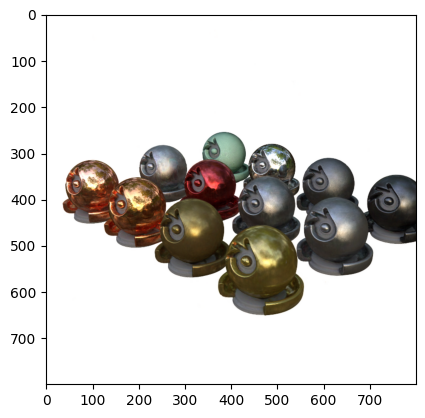

In [4]:
torch.cuda.empty_cache()
tensorf.model.max_retrace_rays=[400000]
tensorf.model.max_brdf_rays=[500000, 500000]
tensorf.eval_batch_size=5000
tensorf.model.russian_roulette = True


brender = BundleRender(chunk_renderer, h, w, 1)
ims, stats = brender(rays, tensorf, N_samples=-1, ndc_ray=False, is_train=False)
disp_im((ims['rgb_map'].clip(0, 1)*255).numpy().astype(np.uint8))

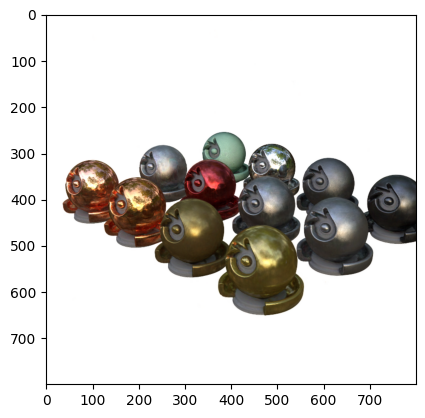

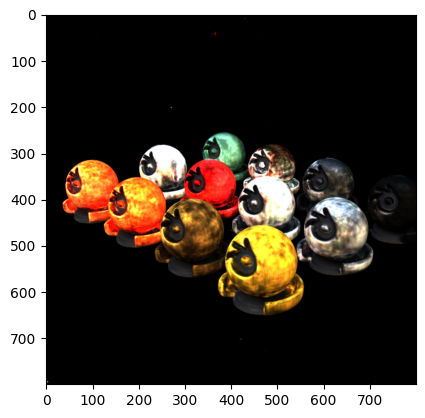

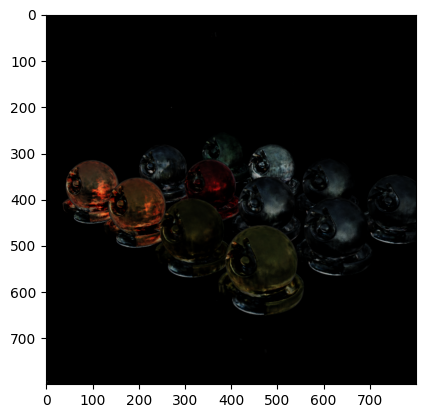

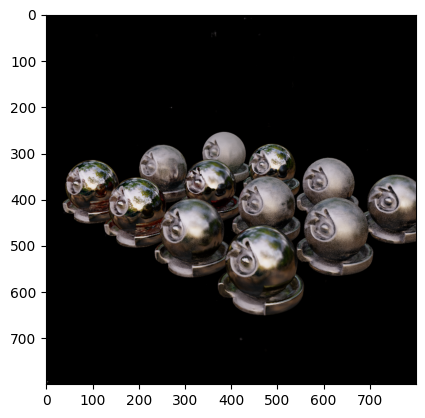

In [5]:
disp_im((ims['rgb_map'].clip(0, 1)*255).numpy().astype(np.uint8))
disp_im((ims['diffuse'].clip(0, 1)*255).numpy().astype(np.uint8))
disp_im((ims['tint'].clip(0, 1)*255).numpy().astype(np.uint8))
disp_im((ims['spec'] / (ims['spec']+1)*255).numpy().astype(np.uint8))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


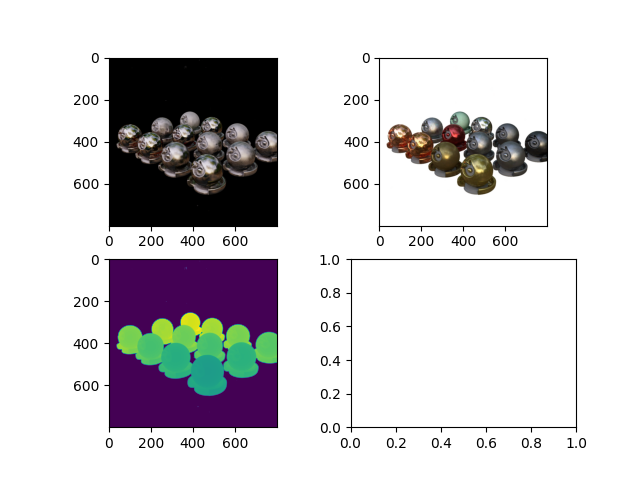

In [6]:
fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(ims['spec'] / (ims['spec']+1))
ax[0, 1].imshow(ims['rgb_map'])
ax[1, 0].imshow(ims['depth'])

In [31]:
pixel = [355, 395]
# pixel = [500, 330]
# pixel = [650, 500]
# pixel = [500, 600]
# pixel = [500, 650]
depth = ims['depth'][pixel[1], pixel[0]]
print(ims.keys())

ind = pixel[1] * w + pixel[0]
ray_p = rays[ind].to(device).reshape(1, 6)
xyz = ray_p[:, :3] + ray_p[:, 3:]
xyz = torch.cat([xyz, torch.zeros((1, 1), device=device)], dim=-1)
xyz = ims['termination_xyz'][pixel[1], pixel[0]].to(device).reshape(1, 4)
print(xyz)
print(xyz)
feat = tensorf.rf.compute_appfeature(xyz)
brdf_im = tensorf.model.graph_brdfs(xyz, ray_p[:, 3:], feat, 100).cpu()
print(brdf_im.max())
disp_im(brdf_im.numpy())


dict_keys(['cross_section', 'depth', 'world_normal', 'normal', 'termination_xyz', 'surf_width', 'diffuse', 'roughness', 'tint', 'spec', 'rgb_map', 'acc_map'])
tensor([[-0.1775, -0.0354, -0.0220,  0.0000]], device='cuda:0')
tensor([[-0.1775, -0.0354, -0.0220,  0.0000]], device='cuda:0')
tensor(0.0001)


NotImplementedError: Axes3D currently only supports the aspect argument 'auto'. You passed in 'equal'.

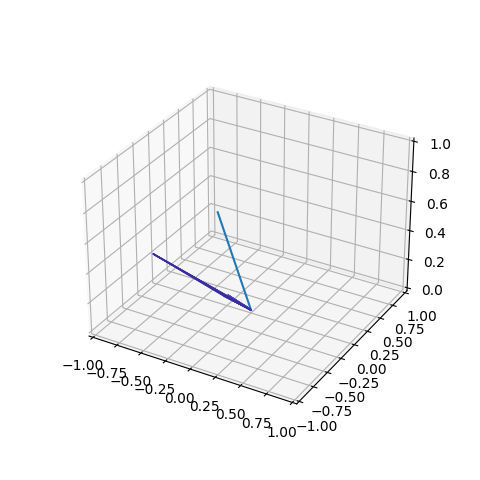

In [32]:
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

phi = -np.linspace(0, np.pi, brdf_im.shape[1])
theta = np.linspace(0, 2*np.pi, brdf_im.shape[0])
phi, theta = np.meshgrid(phi, theta)
brdf_im = brdf_im / brdf_im.mean(dim=-1).max()

bright = brdf_im.max(dim=-1).values.numpy()
# bright = np.ones_like(bright)

# The Cartesian coordinates of the unit sphere
x = np.sin(phi) * np.cos(theta) * bright
y = np.sin(phi) * np.sin(theta) * bright
z = np.cos(phi) * bright

fcolors = brdf_im.numpy()/bright.clip(min=1e-10).reshape(*bright.shape, 1)

fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, -z,  rstride=1, cstride=1, facecolors=fcolors)
ray_np = ray_p.cpu().numpy().reshape(-1)
ax.plot([0, ray_np[3]], [0, ray_np[4]], [0, -ray_np[5]])
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(0, 1)
# Turn off the axis planes
# ax.set_axis_off()
plt.show()